In [1]:
import os
import glob
import napari
import pandas as pd
import numpy as np
import mahotas as mh

from pathlib import Path
from aicsimageio import AICSImage, readers
from blimp.preprocessing.illumination_correction import IlluminationCorrection

from PIL import Image
from matplotlib import cm

#data_dir = "/srv/scratch/berrylab/z3532965/NikonSpinningDisk/240315/240314_ARMC5KO_PolyA"
data_dir = "/srv/scratch/berrylab/z3532965/NikonSpinningDisk/240322/240322_ARMC5KO_PolyA"
#image_dir = os.path.join(data_dir,"20240315_142116_487/OME-TIFF-MIP")
image_dir = os.path.join(data_dir,"20240322_143358_441/OME-TIFF-MIP")
#label_image_dir = os.path.join(data_dir,"20240315_142116_487/SEGMENTATION")
label_image_dir = os.path.join(data_dir,"20240322_143358_441/SEGMENTATION")

ana_dir = "/srv/scratch/z3532965/src/publications/2024_ARMC5/hek_polyA"
#illum_corr_file = os.path.join(data_dir,"/srv/scratch/berrylab/z3532965/NikonSpinningDisk/240315/240314_ARMC5KO_PolyA/ILLUMCORR/illumination_correction.pkl")
illum_corr_file = os.path.join(data_dir,"/srv/scratch/berrylab/z3532965/NikonSpinningDisk/240322/240322_ARMC5KO_PolyA/ILLUMCORR/illumination_correction.pkl")

01-Aug-24 11:40:33 - bfio.backends - WARNING  - Java backend is not available. This could be due to a missing dependency (jpype).


In [2]:
def create_overlay_image_plot(
        channel_image, label_image,
        color='rgb(255, 191, 0)', thin=False):

    # threshold label_image and generate outlines
    label_image = np.array(label_image)
    if (thin):
        outlines = mh.labeled.borders(label_image) * 255
    else:
        outlines = mh.morph.dilate(mh.labeled.borders(label_image)) * 255
    overlay = Image.fromarray(np.uint8(outlines))
    outlines_transparent = Image.new(
        mode='RGBA', size=outlines.shape[::-1], color=(0, 0, 0, 0)
    )

    channel_image = channel_image.convert("RGBA")
    outlines_transparent.paste(channel_image, (0,0))
    outlines_transparent.paste(overlay, (0,0), mask=overlay)

    return outlines_transparent

## Load metadata
We have a csv file of the plate layout that includes information on antibody staining

In [3]:
import re

plate_layout = pd.read_csv(os.path.join(ana_dir,"METADATA","240311_ARMC5KO_PolyA_longlayout.csv"))
plate_layout.columns

def pad_well_names(name):
    return re.sub(r'(\D)(\d)$', r'\g<1>0\2', name)

# Apply the function to the DataFrame column in place
plate_layout['Well_name'] = plate_layout['Well_name'].apply(lambda x: pad_well_names(x))

In [4]:
plate_layout

,Well_name,Cell,Hybridisation
0,C03,HEK293 parental,ATTO647N poly(T)
1,D03,HEK293 ARMC5 KO 1A3,ATTO647N poly(T)
2,E03,HEK293 ARMC5 KO 2B6,ATTO647N poly(T)
3,F03,HEK293 parental,ATTO647N poly(T)
4,G03,HEK293 ARMC5 KO 1A3,ATTO647N poly(T)
5,H03,HEK293 ARMC5 KO 2B6,ATTO647N poly(T)
6,I03,HEK293 parental,ATTO647N poly(T)
7,J03,HEK293 ARMC5 KO 1A3,ATTO647N poly(T)
8,K03,HEK293 ARMC5 KO 2B6,ATTO647N poly(T)
9,C04,HEK293 parental,ATTO647N poly(T)


## Apply illumination correction

Load illumination correction object

In [5]:
illumination_correction = IlluminationCorrection(from_file=illum_corr_file)

## Join image metadata and plate layout

In [6]:
image_metadata_files = glob.glob(os.path.join(image_dir,"*.csv"))
image_metadata = pd.concat((pd.read_csv(f) for f in image_metadata_files), ignore_index=True)
image_metadata['well_name'] = image_metadata['filename_ome_tiff'].str.extract(r'Well([A-Z]\d{2})_Channel')
image_metadata.columns

Index(['n_pixels_y', 'n_pixels_x', 'objective_name', 'pixel_size_microns',
       'field_id', 'timepoint_id', 'filename_ome_tiff', 'acquisition_time_rel',
       'stage_y_abs', 'stage_x_abs', 'stage_z_n', 'acquisition_time_abs',
       'standard_field_id', 'metadata_string_acquisition_0',
       'metadata_string_acquisition_1', 'metadata_string_acquisition_2',
       'metadata_string_acquisition_3', 'well_name'],
      dtype='object')

In [7]:
image_metadata_annotated = image_metadata.merge(plate_layout,left_on="well_name", right_on="Well_name")

In [8]:
image_metadata_annotated.query(
    "Cell == 'HEK293 parental' and Hybridisation == 'ATTO647N poly(T)' and field_id == 1")

,n_pixels_y,n_pixels_x,objective_name,pixel_size_microns,field_id,timepoint_id,filename_ome_tiff,acquisition_time_rel,stage_y_abs,stage_x_abs,...,acquisition_time_abs,standard_field_id,metadata_string_acquisition_0,metadata_string_acquisition_1,metadata_string_acquisition_2,metadata_string_acquisition_3,well_name,Well_name,Cell,Hybridisation
0,2304,2304,Plan Apo λ 40x,0.1625,1,0,"WellF03_Channel647,405,None,488_Seq0007_0001.o...",1719.120378,-12480.480952,43262.428571,...,2024-03-22 15:34:59.120378,4,Plane #1:\n Name: 647\n Component Count: 1\n M...,Plane #2:\n Name: 405\n Component Count: 1\n M...,Plane #3:\n Name: None\n Component Count: 1\n ...,Plane #4:\n Name: 488\n Component Count: 1\n M...,F03,F03,HEK293 parental,ATTO647N poly(T)
16,2304,2304,Plan Apo λ 40x,0.1625,1,0,"WellF04_Channel647,405,None,488_Seq0006_0001.o...",1476.064173,-12482.561905,38775.600000,...,2024-03-22 15:26:53.064173,4,Plane #1:\n Name: 647\n Component Count: 1\n M...,Plane #2:\n Name: 405\n Component Count: 1\n M...,Plane #3:\n Name: None\n Component Count: 1\n ...,Plane #4:\n Name: 488\n Component Count: 1\n M...,F04,F04,HEK293 parental,ATTO647N poly(T)
32,2304,2304,Plan Apo λ 40x,0.1625,1,0,"WellC04_Channel647,405,None,488_Seq0001_0001.o...",255.100495,-25949.985714,38774.800000,...,2024-03-22 14:46:12.100495,4,Plane #1:\n Name: 647\n Component Count: 1\n M...,Plane #2:\n Name: 405\n Component Count: 1\n M...,Plane #3:\n Name: None\n Component Count: 1\n ...,Plane #4:\n Name: 488\n Component Count: 1\n M...,C04,C04,HEK293 parental,ATTO647N poly(T)
128,2304,2304,Plan Apo λ 40x,0.1625,1,0,"WellC03_Channel647,405,None,488_Seq0000_0001.o...",8.356127,-25947.900000,43261.800000,...,2024-03-22 14:37:58.356127,4,Plane #1:\n Name: 647\n Component Count: 1\n M...,Plane #2:\n Name: 405\n Component Count: 1\n M...,Plane #3:\n Name: None\n Component Count: 1\n ...,Plane #4:\n Name: 488\n Component Count: 1\n M...,C03,C03,HEK293 parental,ATTO647N poly(T)
272,2304,2304,Plan Apo λ 40x,0.1625,1,0,"WellI03_Channel647,405,None,488_Seq0012_0001.o...",2937.687853,986.847619,43263.271429,...,2024-03-22 16:15:35.687853,4,Plane #1:\n Name: 647\n Component Count: 1\n M...,Plane #2:\n Name: 405\n Component Count: 1\n M...,Plane #3:\n Name: None\n Component Count: 1\n ...,Plane #4:\n Name: 488\n Component Count: 1\n M...,I03,I03,HEK293 parental,ATTO647N poly(T)


## Save Examples

In [9]:
example_images = image_metadata_annotated.query("field_id == 4")[['filename_ome_tiff','Hybridisation','Cell','well_name']]
example_images['new_filename'] = example_images['Cell'] + '_' + example_images['Hybridisation'] + '_' + example_images['well_name'] + '.png'
example_images['new_filename_overlay'] = example_images['Cell'] + '_' + example_images['Hybridisation'] + '_' + example_images['well_name'] + '_nuclei.png'
example_images['new_filename_overlay_cell'] = example_images['Cell'] + '_' + example_images['Hybridisation'] + '_' + example_images['well_name'] + '_nuclei_cell.png'
example_images['nuclei_segmentation_filename'] = 'nuclei_' + example_images['filename_ome_tiff']
example_images['cell_segmentation_filename'] = 'cell_' + example_images['filename_ome_tiff']
example_images['intensity_rescaling_group'] = 'A'

In [10]:
example_images

,filename_ome_tiff,Hybridisation,Cell,well_name,new_filename,new_filename_overlay,new_filename_overlay_cell,nuclei_segmentation_filename,cell_segmentation_filename,intensity_rescaling_group
3,"WellF03_Channel647,405,None,488_Seq0007_0004.o...",ATTO647N poly(T),HEK293 parental,F03,HEK293 parental_ATTO647N poly(T)_F03.png,HEK293 parental_ATTO647N poly(T)_F03_nuclei.png,HEK293 parental_ATTO647N poly(T)_F03_nuclei_ce...,"nuclei_WellF03_Channel647,405,None,488_Seq0007...","cell_WellF03_Channel647,405,None,488_Seq0007_0...",A
19,"WellF04_Channel647,405,None,488_Seq0006_0004.o...",ATTO647N poly(T),HEK293 parental,F04,HEK293 parental_ATTO647N poly(T)_F04.png,HEK293 parental_ATTO647N poly(T)_F04_nuclei.png,HEK293 parental_ATTO647N poly(T)_F04_nuclei_ce...,"nuclei_WellF04_Channel647,405,None,488_Seq0006...","cell_WellF04_Channel647,405,None,488_Seq0006_0...",A
35,"WellC04_Channel647,405,None,488_Seq0001_0004.o...",ATTO647N poly(T),HEK293 parental,C04,HEK293 parental_ATTO647N poly(T)_C04.png,HEK293 parental_ATTO647N poly(T)_C04_nuclei.png,HEK293 parental_ATTO647N poly(T)_C04_nuclei_ce...,"nuclei_WellC04_Channel647,405,None,488_Seq0001...","cell_WellC04_Channel647,405,None,488_Seq0001_0...",A
51,"WellG04_Channel647,405,None,488_Seq0009_0004.o...",ATTO647N poly(T),HEK293 ARMC5 KO 1A3,G04,HEK293 ARMC5 KO 1A3_ATTO647N poly(T)_G04.png,HEK293 ARMC5 KO 1A3_ATTO647N poly(T)_G04_nucle...,HEK293 ARMC5 KO 1A3_ATTO647N poly(T)_G04_nucle...,"nuclei_WellG04_Channel647,405,None,488_Seq0009...","cell_WellG04_Channel647,405,None,488_Seq0009_0...",A
67,"WellE03_Channel647,405,None,488_Seq0004_0004.o...",ATTO647N poly(T),HEK293 ARMC5 KO 2B6,E03,HEK293 ARMC5 KO 2B6_ATTO647N poly(T)_E03.png,HEK293 ARMC5 KO 2B6_ATTO647N poly(T)_E03_nucle...,HEK293 ARMC5 KO 2B6_ATTO647N poly(T)_E03_nucle...,"nuclei_WellE03_Channel647,405,None,488_Seq0004...","cell_WellE03_Channel647,405,None,488_Seq0004_0...",A
83,"WellG03_Channel647,405,None,488_Seq0008_0004.o...",ATTO647N poly(T),HEK293 ARMC5 KO 1A3,G03,HEK293 ARMC5 KO 1A3_ATTO647N poly(T)_G03.png,HEK293 ARMC5 KO 1A3_ATTO647N poly(T)_G03_nucle...,HEK293 ARMC5 KO 1A3_ATTO647N poly(T)_G03_nucle...,"nuclei_WellG03_Channel647,405,None,488_Seq0008...","cell_WellG03_Channel647,405,None,488_Seq0008_0...",A
99,"WellD04_Channel647,405,None,488_Seq0002_0004.o...",ATTO647N poly(T),HEK293 ARMC5 KO 1A3,D04,HEK293 ARMC5 KO 1A3_ATTO647N poly(T)_D04.png,HEK293 ARMC5 KO 1A3_ATTO647N poly(T)_D04_nucle...,HEK293 ARMC5 KO 1A3_ATTO647N poly(T)_D04_nucle...,"nuclei_WellD04_Channel647,405,None,488_Seq0002...","cell_WellD04_Channel647,405,None,488_Seq0002_0...",A
115,"WellD03_Channel647,405,None,488_Seq0003_0004.o...",ATTO647N poly(T),HEK293 ARMC5 KO 1A3,D03,HEK293 ARMC5 KO 1A3_ATTO647N poly(T)_D03.png,HEK293 ARMC5 KO 1A3_ATTO647N poly(T)_D03_nucle...,HEK293 ARMC5 KO 1A3_ATTO647N poly(T)_D03_nucle...,"nuclei_WellD03_Channel647,405,None,488_Seq0003...","cell_WellD03_Channel647,405,None,488_Seq0003_0...",A
131,"WellC03_Channel647,405,None,488_Seq0000_0004.o...",ATTO647N poly(T),HEK293 parental,C03,HEK293 parental_ATTO647N poly(T)_C03.png,HEK293 parental_ATTO647N poly(T)_C03_nuclei.png,HEK293 parental_ATTO647N poly(T)_C03_nuclei_ce...,"nuclei_WellC03_Channel647,405,None,488_Seq0000...","cell_WellC03_Channel647,405,None,488_Seq0000_0...",A
147,"WellE04_Channel647,405,None,488_Seq0005_0004.o...",ATTO647N poly(T),HEK293 ARMC5 KO 2B6,E04,HEK293 ARMC5 KO 2B6_ATTO647N poly(T)_E04.png,HEK293 ARMC5 KO 2B6_ATTO647N poly(T)_E04_nucle...,HEK293 ARMC5 KO 2B6_ATTO647N poly(T)_E04_nucle...,"nuclei_WellE04_Channel647,405,None,488_Seq0005...","cell_WellE04_Channel647,405,None,488_Seq0005_0...",A


In [11]:
from pathlib import Path
example_dir = Path(image_dir).parent / 'EXAMPLES' / 'RGB'
example_overlay_dir = Path(image_dir).parent / 'EXAMPLES' / 'RGB_OVERLAY'
if not example_dir.exists(): 
    example_dir.mkdir(parents=True)
if not example_overlay_dir.exists(): 
    example_overlay_dir.mkdir(parents=True)

In [12]:
%%capture
example_images_grouped = example_images.query("Hybridisation == 'ATTO647N poly(T)'").groupby('intensity_rescaling_group')
upper_rescale_values = {}
for group_name, group_data in example_images_grouped:
    group_of_image_files = group_data['filename_ome_tiff'].to_list()
    upper_rescale_value = []
    for image_filename in group_of_image_files:
        aics_image = AICSImage(Path(image_dir) / image_filename, reader=readers.ome_tiff_reader.OmeTiffReader )
        aics_image = illumination_correction.correct(aics_image)
        IF_array = aics_image.get_image_data('YX',Z=0,C=2,T=0)[500:,:] # crop
        upper_rescale_value.append(np.quantile(IF_array,0.995))
    upper_rescale_values[group_name] = max(upper_rescale_value)

In [13]:
upper_rescale_values_df = pd.DataFrame(upper_rescale_values.items(), columns=['intensity_rescaling_group','upper_rescale_value'])
upper_rescale_values_df
example_images = example_images.merge(upper_rescale_values_df,on="intensity_rescaling_group")

In [14]:
%%capture
for index, row in example_images.iterrows():
    aics_image = AICSImage(Path(image_dir) / row["filename_ome_tiff"], reader=readers.ome_tiff_reader.OmeTiffReader)
    aics_image = illumination_correction.correct(aics_image)
    IF_array = aics_image.get_image_data('YX',Z=0,C=2,T=0)[:,500:] # crop
    lower_rescale_value = 120
    IF_array_rescaled = (IF_array.astype(float) - lower_rescale_value) / row["upper_rescale_value"]
    pil_image = Image.fromarray(cm.magma(IF_array_rescaled.clip(0,1),bytes=True)).convert('RGB')
    pil_image.save(str(example_dir / row["new_filename"]), quality=85, subsampling=0)
    
    # add nuclei segmentation overlay
    segmentation_aics_image = AICSImage(Path(label_image_dir) / row["nuclei_segmentation_filename"], reader=readers.ome_tiff_reader.OmeTiffReader)
    segmentation_array = segmentation_aics_image.get_image_data('YX',Z=0,C=0,T=0) # already cropped
    segmentation_pil_image = Image.fromarray(segmentation_array)
    overlay_image = create_overlay_image_plot(pil_image,segmentation_pil_image,thin=True)
    overlay_image.save(str(example_overlay_dir / row["new_filename_overlay"]), quality=85, subsampling=0)
    
    # add cell segmentation overlay
    segmentation_aics_image = AICSImage(Path(label_image_dir) / row["cell_segmentation_filename"], reader=readers.ome_tiff_reader.OmeTiffReader)
    segmentation_array = segmentation_aics_image.get_image_data('YX',Z=0,C=0,T=0) # already cropped
    segmentation_pil_image = Image.fromarray(segmentation_array)
    overlay_image = create_overlay_image_plot(overlay_image,segmentation_pil_image,thin=True)
    overlay_image.save(str(example_overlay_dir / row["new_filename_overlay_cell"]), quality=85, subsampling=0)

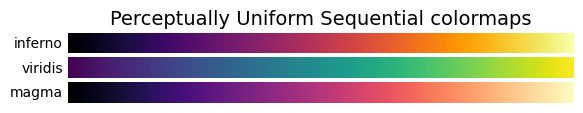

In [15]:
import matplotlib.pyplot as plt
import numpy as np

cmaps = [('Perceptually Uniform Sequential', [
            'viridis', 'plasma', 'inferno', 'magma', 'cividis']),
         ('Sequential', [
            'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']),
         ('Sequential (2)', [
            'binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink',
            'spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia',
            'hot', 'afmhot', 'gist_heat', 'copper']),
         ('Diverging', [
            'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
            'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']),
         ('Cyclic', ['twilight', 'twilight_shifted', 'hsv']),
         ('Qualitative', [
            'Pastel1', 'Pastel2', 'Paired', 'Accent',
            'Dark2', 'Set1', 'Set2', 'Set3',
            'tab10', 'tab20', 'tab20b', 'tab20c']),
         ('Miscellaneous', [
            'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
            'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg',
            'gist_rainbow', 'rainbow', 'jet', 'turbo', 'nipy_spectral',
            'gist_ncar'])]

gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

def plot_color_gradients(cmap_category, cmap_list):
    # Create figure and adjust figure height to number of colormaps
    nrows = len(cmap_list)
    figh = 0.35 + 0.15 + (nrows + (nrows-1)*0.1)*0.22
    fig, axs = plt.subplots(nrows=nrows, figsize=(6.4, figh))
    fig.subplots_adjust(top=1-.35/figh, bottom=.15/figh, left=0.2, right=0.99)

    axs[0].set_title(f"{cmap_category} colormaps", fontsize=14)

    for ax, cmap_name in zip(axs, cmap_list):
        ax.imshow(gradient, aspect='auto', cmap=cmap_name)
        ax.text(-.01, .5, cmap_name, va='center', ha='right', fontsize=10,
                transform=ax.transAxes)

    # Turn off *all* ticks & spines, not just the ones with colormaps.
    for ax in axs:
        ax.set_axis_off()
        
    return fig


colormaps = plot_color_gradients('Perceptually Uniform Sequential', ['inferno','viridis','magma'])

colormaps.savefig(str(Path(image_dir).parent / 'EXAMPLES' / 'colormap.png'))

In [16]:
example_dir

PosixPath('/srv/scratch/berrylab/z3532965/NikonSpinningDisk/240322/240322_ARMC5KO_PolyA/20240322_143358_441/EXAMPLES/RGB')

In [17]:
aics_image.channel_names

['647', '405', 'None', '488']